In [1]:
#!dcm2niix -h
#!dcm2niix Brain_T1_scan_Patient1


In [20]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2

#Brain from classical patient with and without skull extraction
file_path = "Data/Brain_T1.nii"
img=nib.load(file_path)
data=img.get_fdata()

file_path = "Data/BrainMask.nii.gz"
img=nib.load(file_path)
data_brain=img.get_fdata()

#Brain from alcoolic patient
file_path = "Data/P2_T1.nii.gz"
img=nib.load(file_path)
data_alcool=img.get_fdata()

In [21]:
#Rotate images
for i in range(len(data)):
    data[i] = np.rot90(data[i],axes=(-2,-1))
    data_brain[i] = np.rot90(data_brain[i],axes=(-2,-1))
    data_alcool[i] = np.rot90(data_alcool[i],axes=(-2,-1))   

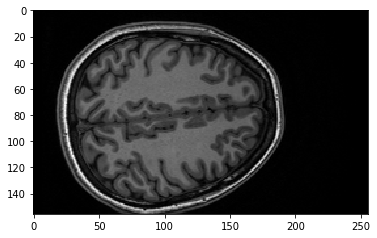

In [22]:

plt.imshow(data[:,50,:], cmap='gray')
plt.show()


In [23]:
grey_im = (data[50]*(255/data[50].max())).astype(np.uint8)

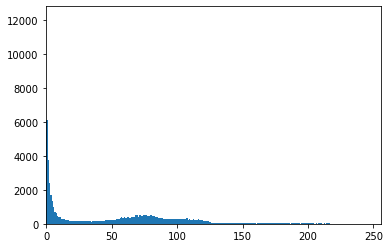

In [24]:
#https://stackoverflow.com/questions/22159160/python-calculate-histogram-of-image
counts, bins = np.histogram(grey_im, range(256))
# plot histogram centered on values 0..255

plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
plt.xlim([-0.5, 255.5])
plt.show()

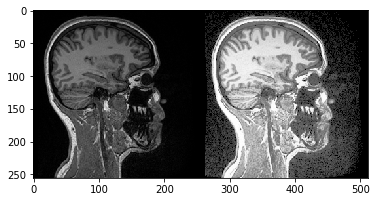

10


In [25]:
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html
import cv2


img = grey_im
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side

plt.imshow(res, cmap='gray')
plt.show()
print(img[200][200])

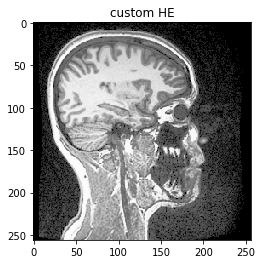

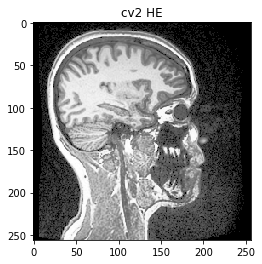

In [26]:
#Own implementation of the histogram equalization

#The goal of the H.E is to have a linear cumulative distribution function (cdf)
#a cross the range of intensity to have a better use of all possible intensities.
#
import math


def hist_equalizer(img):
    
    result = np.zeros(img.shape).astype(np.uint8)
    
    #Set the range of intensity of the image between 0 and 255 and as unsigned integers
    grey_im = (img*(255/img.max())).astype(np.uint8)
    
    #Create the histogram
    #We got up to 256 because the last bin is [255,256] while all the others are [n-1,n[
    #meaning that the last bin would have sum the pixels with value 254 and 255 if we had stop at 255
    counts, bins = np.histogram(grey_im.flatten(),256, [0,256])
    
    #Create the cdf
    cdf = counts.cumsum()
    cdf_min = cdf[np.nonzero(cdf)[0][0]] #first element that is not zero
    
    i_max, j_max = img.shape
    
    for i in range(i_max):
        for j in range(j_max):
            #value in the original image to be transformed
            val = grey_im[i][j]

            #we just take the normalized cdf of the value by the inverse distribution 
            #function (quantile function) multiply it by 255 (the max range) and round the result
            result[i][j] = math.floor((cdf[val] - cdf_min)/(i_max*j_max - cdf_min)*(256-1))

    return result

custom_res = hist_equalizer(data[50])

plt.imshow(custom_res,cmap='gray')
plt.title("custom HE")
plt.show()

plt.imshow(equ,cmap='gray')
plt.title("cv2 HE")
plt.show()

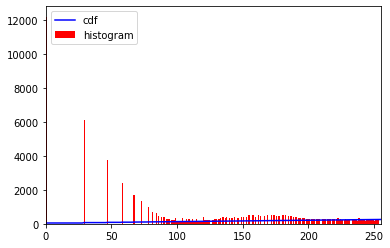

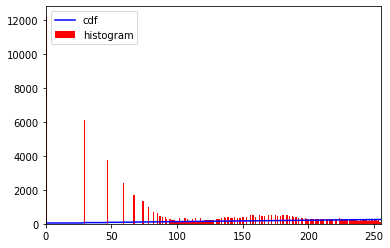

In [27]:
#Comparing histogram of custom and cv2 histogram equalizer

hists, bins = np.histogram(custom_res, 256)
cdf = hists.cumsum()
cdf_normalized = cdf * 255/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(custom_res.flatten(), 256,[0,255], color = 'r')
plt.xlim([0,255])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

hists, bins = np.histogram(equ, 256)
cdf = hists.cumsum()
cdf_normalized = cdf * 255/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,255], color = 'r')
plt.xlim([0,255])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

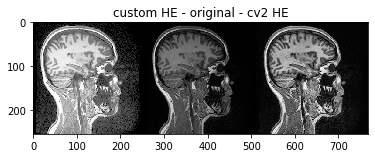

In [28]:
#Contrast-limited adaptive histogram equalization (CLAHE) consist of dividing the image into tiles
#and apply the equalization localy. There is also a threshold to limit the contrast
#TODO better explanation

img = grey_im
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) #grid of 8 by 8
cl1 = clahe.apply(img)
res = np.hstack((custom_res,img,cl1))
plt.imshow(res, cmap='gray')
plt.title('custom HE - original - cv2 HE')
plt.show()

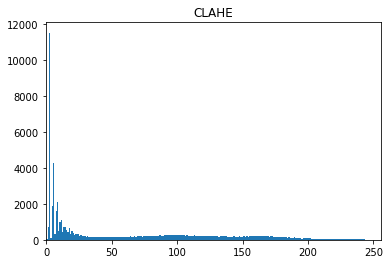

In [29]:
counts, bins = np.histogram(cl1, range(257))
# plot histogram centered on values 0..255
plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
plt.xlim([-0.5, 255.5])
plt.title("CLAHE")
plt.show()

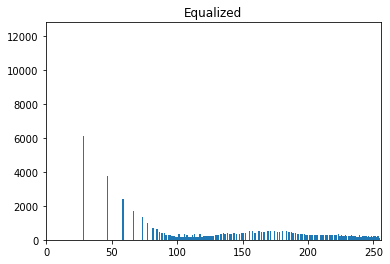

In [30]:
counts, bins = np.histogram(equ, range(257))
# plot histogram centered on values 0..255
plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
plt.xlim([-0.5, 255.5])
plt.title("Equalized")
plt.show()

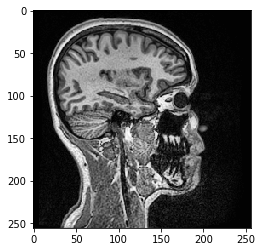

In [31]:
plt.imshow(cl1, cmap='gray')
plt.show()

(156, 256, 256)
(156, 256)


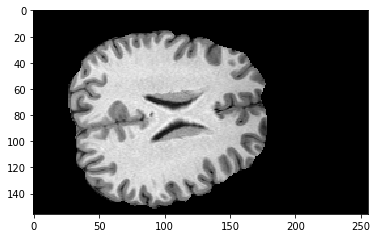

(39936, 1)
(39936,)


In [11]:
#Kmeans segmentation
from sklearn.cluster import KMeans

image = data[:,:,190]


dim = image.shape
print(dim)

plt.imshow(image, cmap='gray')
plt.show()

img_1D = np.reshape(image,(-1,1))
print(img_1D.shape)

km = KMeans(
    n_clusters=3, init='k-means++',
    n_init=10, max_iter=10000, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(img_1D)
print(y_km.shape)

In [18]:
print(y_km.shape)

(39936,)


In [19]:
final = np.reshape(y_km, dim)

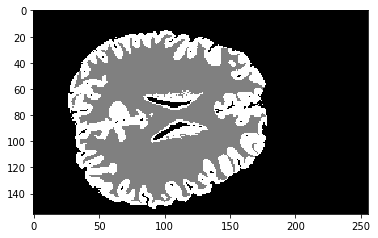

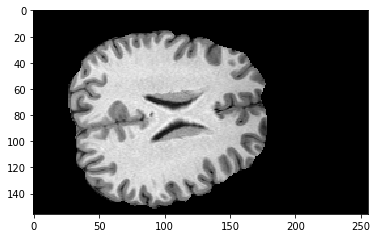

In [20]:
plt.imshow(final, cmap='gray')
plt.show()

plt.imshow(image, cmap='gray')
plt.show()

In [243]:
file_path = "Nifti_Brain/E1_FA.nii"
img=nib.load(file_path)
fadata=img.get_fdata()
print(data.shape)


(110, 110, 68)


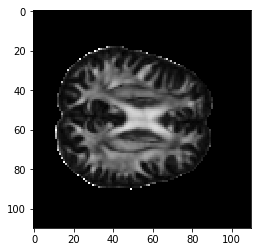

In [245]:
img = fadata[:,:,40]
plt.imshow(img, cmap='gray')
plt.show()

In [227]:
grey_im = (img*(255/1)).astype(np.uint8)
print(img.max())
print(img.min())

0.8158648337826401
0.0


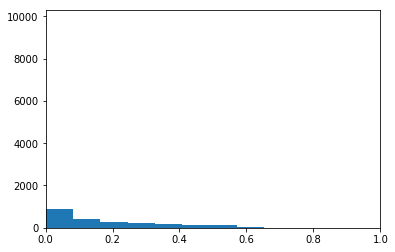

In [228]:
counts, bins = np.histogram(img)
# plot histogram centered on values 0..255

plt.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
plt.xlim([0, 1])
plt.show()


In [229]:
test = np.where(img > 0.67, img, 0)

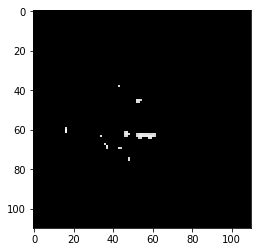

In [230]:
plt.imshow(test, cmap='gray')
plt.show()

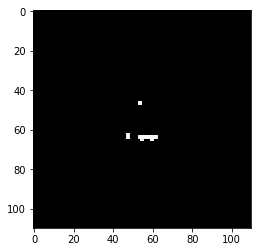

0.058573647692929


In [231]:
#Apply 2 opening with 2 different kernels
kernel = np.ones((1,2),np.uint8)
opening = cv2.morphologyEx(test, cv2.MORPH_OPEN, kernel)
kernel = np.ones((2,1),np.uint8)
opening = cv2.morphologyEx(opening, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap='gray')
plt.show()
print(np.mean(data))

In [238]:
fa_data = np.zeros(data.shape)
for i in range(fadata.shape[2]):
    img = fadata[:,:,i]
    #Apply threshold
    thresh = np.where(img > 0.67, img, 0)
    #Apply morphological operators
    kernel = np.ones((1,2),np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((2,1),np.uint8)
    opening = cv2.morphologyEx(opening, cv2.MORPH_OPEN, kernel)
    fa_data[:,:,i] = opening
print(fa_data.mean())

0.002862174324480648


In [239]:
#for i in range(len(fa_data)):
#    plt.imshow(fa_data[i], cmap='gray')
#    plt.show()

In [ ]:
grey_data = np.zeros(data.shape)
n = 40
flags = cv2.KMEANS_PP_CENTERS
km = KMeans(
    n_clusters=3, init='k-means++',
    n_init=10, max_iter=10000, 
    tol=1e-04, random_state=0#cv2.KMEANS_PP_CENTERS
)
#flatten all images
dim = fadata[:,:,0].shape
print(dim)

for i in range(fadata.shape[2]):
    grey_im = fadata[:,:,i]#(data[:,:,50]*(255/1)).astype(np.uint8)
    img_1D = np.reshape(grey_im,(-1,1))
    y_km = km.fit_predict(img_1D)
    final = np.reshape(y_km, dim)
    grey_data[:,:,i] = final
    

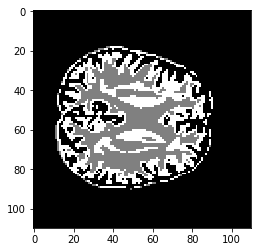

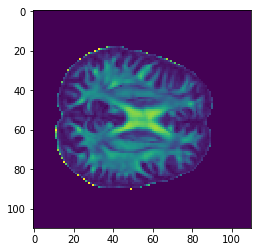

In [246]:
#Create white matter mask because corpus calosum only in white matter

#test
x,y,z = fadata.shape
brainReshape = fadata.reshape(x*y*z)
brainReshape= brainReshape.reshape(-1,1)
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=3, init='k-means++',
    n_init=10, max_iter=10000, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(brainReshape)
brainKmeans = y_km.reshape(x,y,z)
plt.imshow(brainKmeans[:,:,40], cmap='gray')
plt.show()
plt.imshow(fadata[:,:,40])
plt.show()

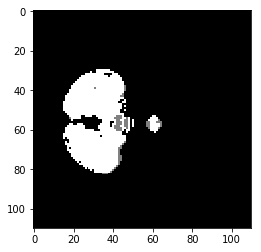

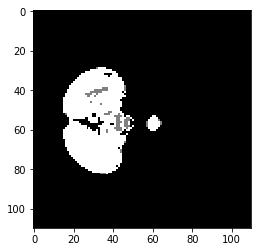

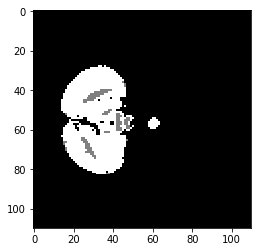

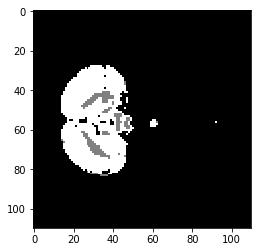

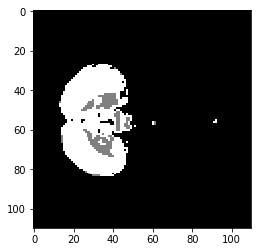

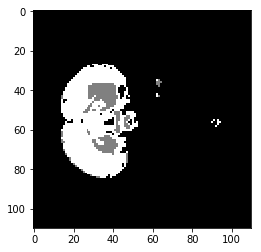

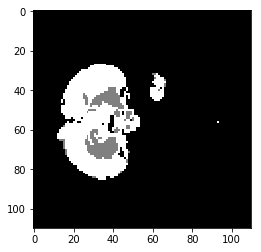

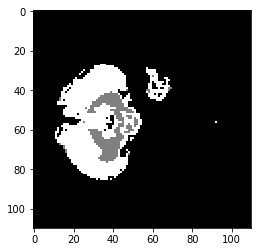

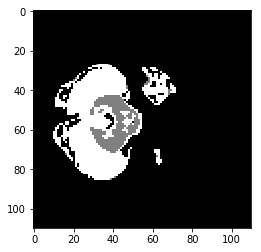

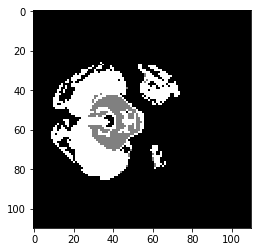

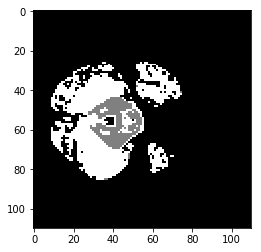

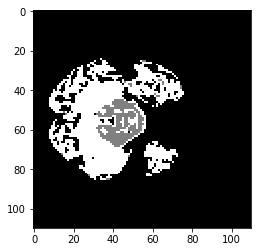

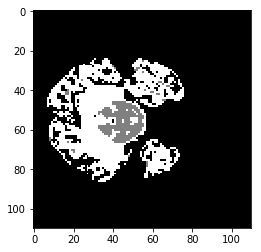

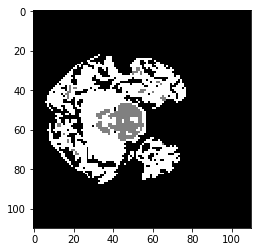

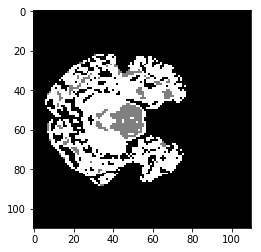

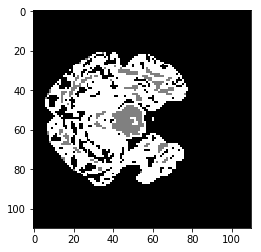

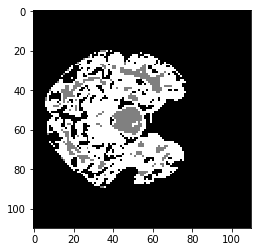

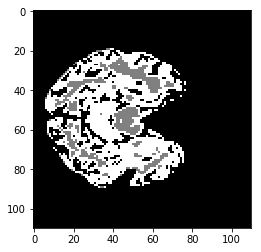

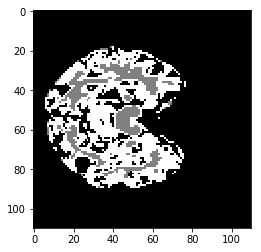

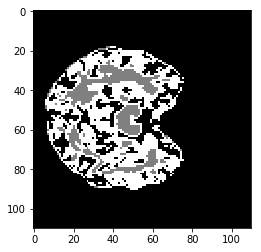

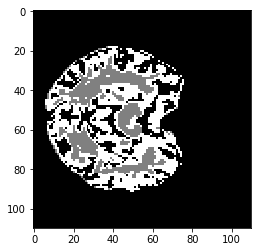

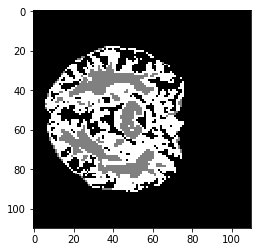

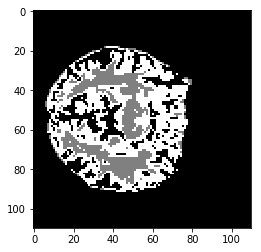

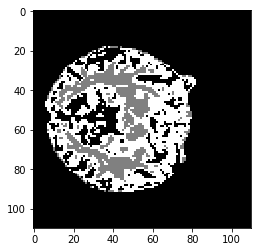

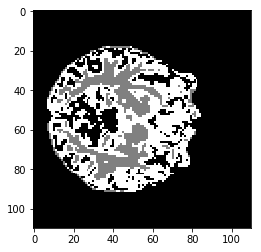

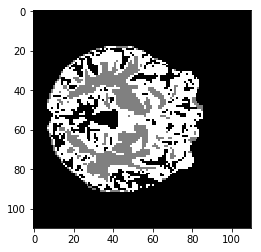

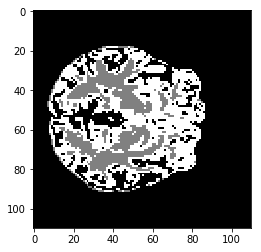

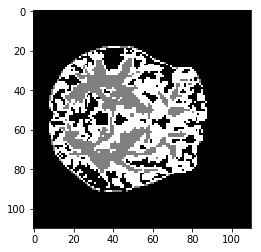

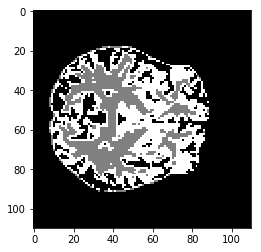

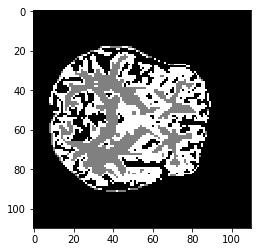

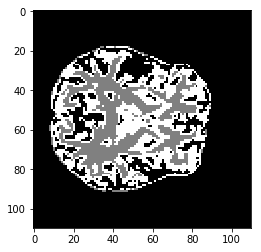

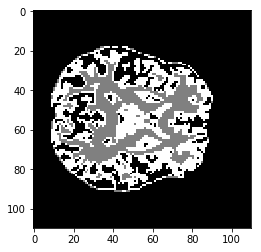

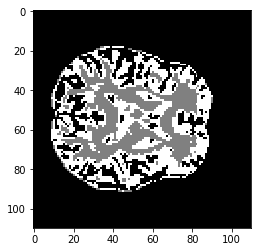

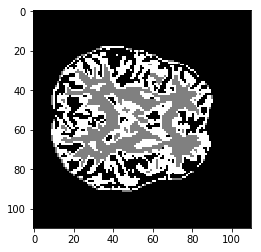

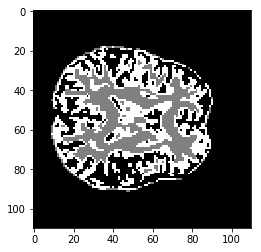

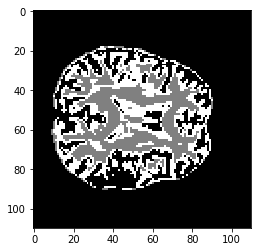

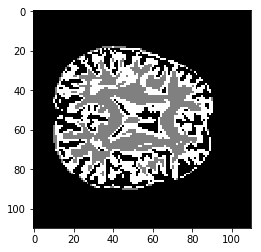

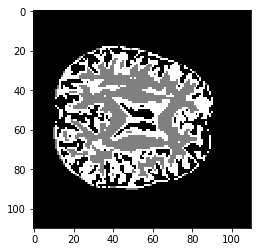

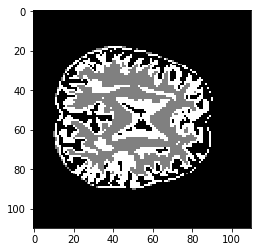

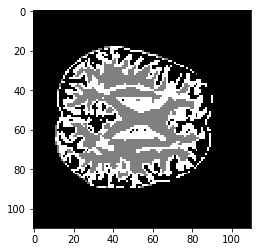

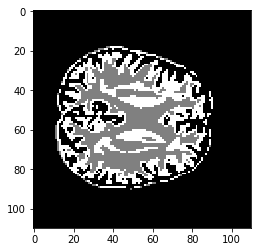

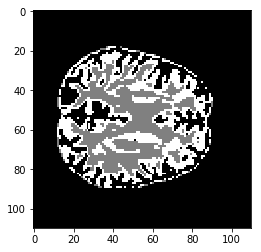

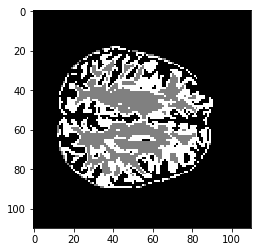

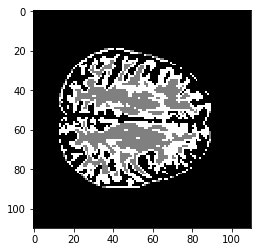

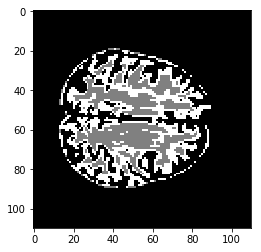

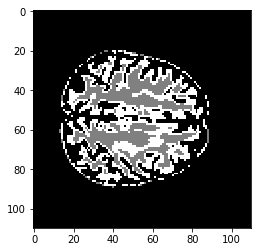

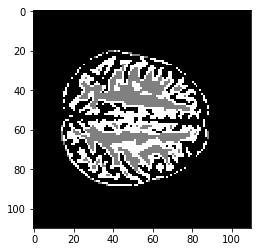

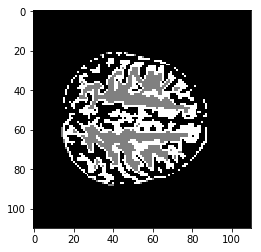

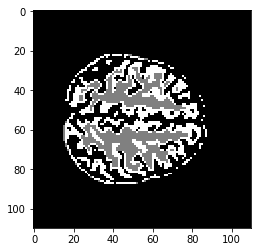

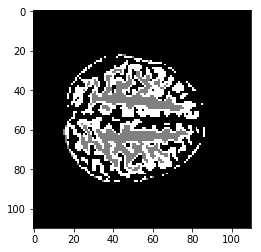

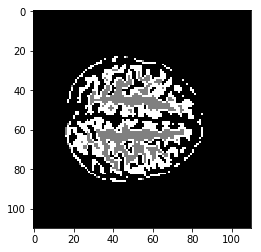

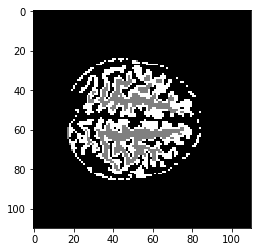

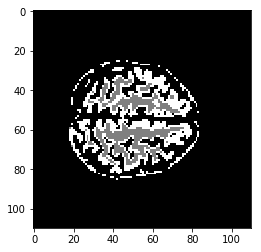

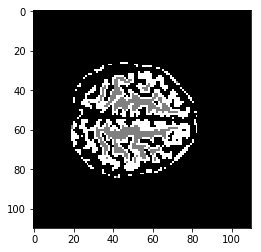

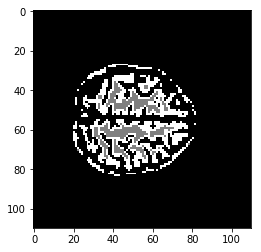

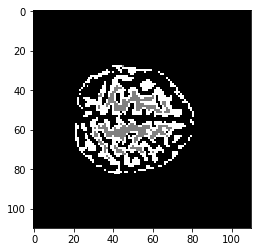

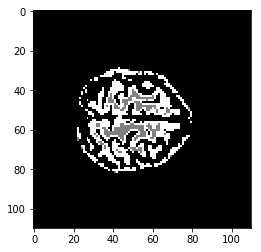

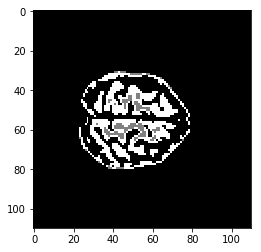

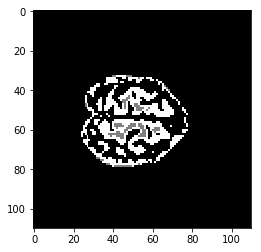

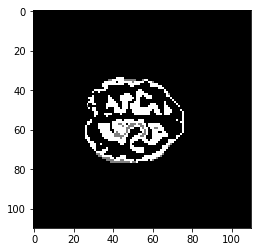

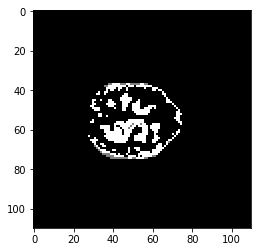

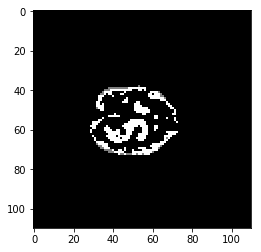

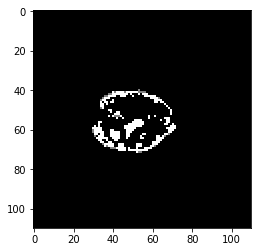

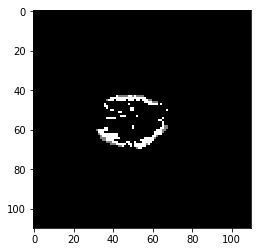

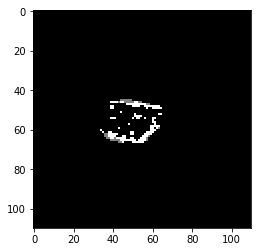

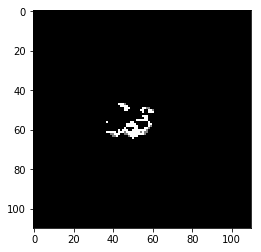

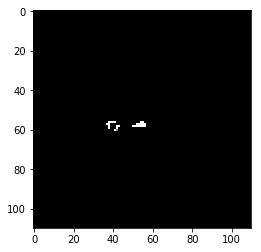

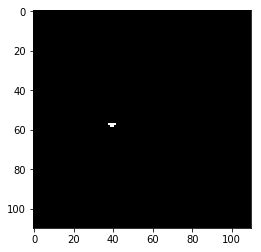

In [247]:
for i in range(fadata.shape[2]):
    plt.imshow(brainKmeans[:,:,i], cmap='gray')
    plt.show()

#grey_im = (data[:,:,1]*(255/1)).astype(np.uint8)
#plt.imshow(data[:,:,40], cmap='gray')
#plt.show()
#plt.imshow(grey_data[:,:,1], cmap='gray')
#plt.show()

In [ ]:
#import pickle
#
#with open('segmentedFA', 'wb') as fp:
#    pickle.dump(grey_data, fp)

In [253]:
test = brainKmeans[:,:,40]
print(test[60,])

[0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 0 2 0 0 0 2 1 1 1 1 1 1 1 2 0 0 2 2 2 2 2 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0
 2 2 2 0 0 0 2 2 2 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


<font size=4> Corpus callosum segmentation </font> <br>

To compute the mask of the corpus callosum we will use the diffuse tensor imaging (DTI) which is based on anisotropic diffusion. This gives us 4 files: the mean diffusivity (MD), the radial diffusivity (RD), the axial diffusivity (AD) and the coloured fractional anisotropy (FA). <br>

The corpus callosum is the white matter that links the two hemisphere of the brain. This makes its fibers close to parallel with the sagital axis. 



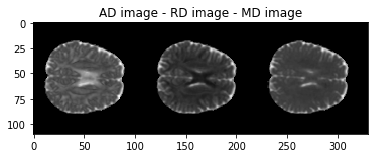

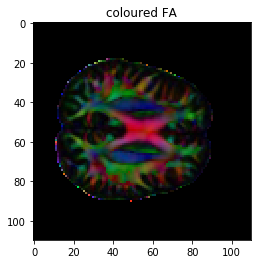

In [12]:
#Visualization of the 4 images
file_path = "Nifti_Brain/E1_color_fa.nii"
cfa=nib.load(file_path)
cfa_data=cfa.get_fdata()
cfa_image = cfa_data[:,:,40]

file_path = "Nifti_Brain/E1_AD.nii"
ad=nib.load(file_path)
ad_data=ad.get_fdata()
ad_image = ad_data[:,:,40]

file_path = "Nifti_Brain/E1_RD.nii"
rd=nib.load(file_path)
rd_data=rd.get_fdata()
rd_image = rd_data[:,:,40]
#plt.imshow(cfa_img)

file_path = "Nifti_Brain/E1_MD.nii"
md=nib.load(file_path)
md_data=md.get_fdata()
md_image = md_data[:,:,40]


clip = np.hstack((ad_image,rd_image, md_image))
plt.imshow(clip, cmap='gray')
plt.title('AD image - RD image - MD image')
plt.show()

plt.imshow(cfa_image)
plt.title("coloured FA")
plt.show()

As we can see in the images above, the CC appears in red in the coloured FA. We will thus work with the red part of the coloured FA image to compute the mask.

<font size= 4>1) Compute the coloured FA mask </font><br>

To do so we start by computing the threshold as equal to 40% of the range of red value in the image<br>

We keep all the pixels with value greater than the threshold then apply 2 openings with first a 1 by 2 rectangle then by a 2 by 1 rectangle to eliminate noisy pixels. This will be the standard behaviour used during all this segmentation so we define the morph_operator function just below

In [96]:
from skimage.morphology import remove_small_objects

def morph_operator(image):
    kernel = np.ones((1,2),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((2,1),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    
    return image


def remove_objects(image, size):
    image_labeled = image > 0
    mask = remove_small_objects(image_labeled, min_size=size)
    mask = np.where(mask, 1, 0)
    
    return mask


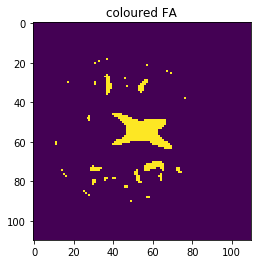

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [88]:
morpho = True

red_cfa_mask = np.zeros(cfa_data[:,:,:,0].shape)

#Threshold computation
min_val = cfa_data[:,:,:,0].min()
max_val = cfa_data[:,:,:,0].max()
threshold = (max_val - min_val) * 0.4

for i in range(cfa_data.shape[2]):
    #take the red colour
    img = cfa_data[:,:,i,0]
    
    #Apply threshold to cfa intensity
    thresh = np.where(img > threshold, 1, img/1.5 + 0.0001)
        
    if morpho:
        #Apply morphological operators
        thresh = morph_operator(thresh)
    red_cfa_mask[:,:,i] = thresh
    
red_cfa_mask = np.where(red_cfa_mask == 1, 1, 0)
 
plt.imshow(red_cfa_mask[:,:,40])
plt.title("coloured FA")
plt.show()
print(red_cfa_mask[50,:,40])

<font size=4>2) Remove small artifacts</font> <br>

We see on the image above that we have a nice segmentation of the corpus callosum but so noisy pixels remain. To remove them we will use the remove_small_object function from the skimage library that remove object in a 3D images that are below a certain size of pixel.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


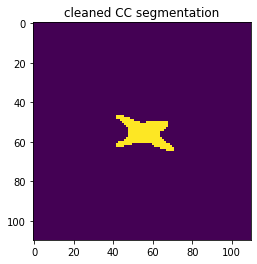

In [97]:
cc_mask = remove_objects(red_cfa_mask, 700)

#uncomment the 2 next lines to save into a nifti image for 3D visualization
#clipped_img = nib.Nifti1Image(cc_mask, ad.affine, ad.header)
#nib.save(clipped_img, 'cc_seg_cleaned_unmorph.nii')

print(cc_mask[50,:,40])

plt.imshow(cleaned[:,:,40])
plt.title("cleaned CC segmentation")
plt.show()

<font size=4> segmentation </font> <br>
The $insert name$ are fibers coming from the $name$ and go up to the $name$. In the coloured FA, they are represented in blue.

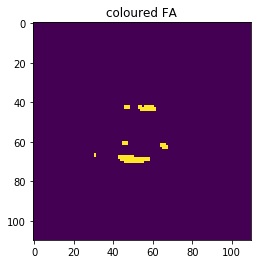

In [110]:
morpho = True

blue_cfa_mask = np.zeros(cfa_data[:,:,:,2].shape)

#Threshold computation
min_val = cfa_data[:,:,:,2].min()
max_val = cfa_data[:,:,:,2].max()
threshold = (max_val - min_val) * 0.4

for i in range(cfa_data.shape[2]):
    #take the blue colour
    img = cfa_data[:,:,i,2]
    
    #Apply threshold to cfa intensity
    thresh = np.where(img > threshold, 1, img/1.5 + 0.0001)
        
    if morpho:
        #Apply morphological operators
        thresh = morph_operator(thresh)
    blue_cfa_mask[:,:,i] = thresh
    
blue_cfa_mask = np.where(blue_cfa_mask == 1, 1, 0)
 
plt.imshow(blue_cfa_mask[:,:,40])
plt.title("coloured FA")
plt.show()

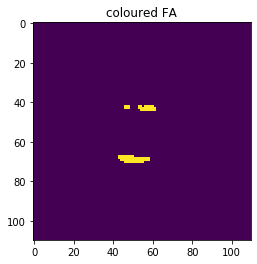

In [138]:
and_mask = (blue_cfa_mask - cc_mask).clip(min=0)

and_mask = remove_objects(and_mask, 2000)

#uncomment the 2 next lines to save into a nifti image for 3D visualization
clipped_img = nib.Nifti1Image(and_mask, ad.affine, ad.header)
nib.save(clipped_img, 'bs_seg_cleaned.nii')

plt.imshow(and_mask[:,:,40])
plt.title("coloured FA")
plt.show()

0.0
0.0036084569764606366
0.0005412685464690955


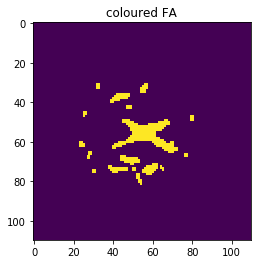

In [131]:
rd_mask = np.zeros(rd_data.shape)

min_val = rd_data.min()
max_val = rd_data.max()
threshold = (max_val - min_val) * 0.15

print(min_val)
print(max_val)
print(threshold)

#Threshold mask for rd_data
for i in range(rd_data.shape[2]):
    img = rd_data[:,:,i]
    #Apply threshold to FA intensity
    min_thresh = np.where(img > 0, 1, img/2)
    max_thresh = np.where(img < threshold, 1,img/3)
    
    bool_mask = np.equal(min_thresh, max_thresh)
    thresh = np.where(bool_mask == True, 1, img)

    if morpho:
        #Apply morphological operators
        thresh = morph_operator(thresh)
    rd_mask[:,:,i] = thresh

rd_mask = np.where(rd_mask == 1, 1, 0)

#rd_mask = remove_objects(rd_mask, 200)
plt.imshow(rd_mask[:,:,40])
plt.title("coloured FA")
plt.show()

In [132]:
#uncomment the 2 next lines to save into a nifti image for 3D visualization
clipped_img = nib.Nifti1Image(rd_mask, ad.affine, ad.header)
nib.save(clipped_img, 'bs_seg_cleaned_and.nii')